# 0. Notebook prep

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import os 
files = os.listdir("loss/")
ae_loss = []
rnn_loss = []
for f in files:
     loss = np.load("loss/"+f)
     loss = np.mean(loss.reshape((100, 100)), axis=-1)
     loss = {"loss":loss}
     if "01" in f:
        loss["lable"] = "alpha = 0.1"
     elif "03" in f:
        loss["lable"] = "alpha = 0.3"
     elif "05" in f:
        loss["lable"] = "alpha = 0.5"
     elif "07" in f:
         loss["lable"] = "alpha = 0.7"
     elif "09" in f:
         loss["lable"] = "alpha = 0.9"
     elif "00" in f:
        loss["lable"] = "rnnlm + encoder"
     else:
        loss["lable"] = "rnnlm"
     if "ae" in f:
        ae_loss.append(loss)
     else:
        rnn_loss.append(loss)

# 1. Recurrent Neural Language Model 

Given the one-hot embeddings $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ of a specific sentence, the RNNLM can assign the probability to the sentence as follow
\begin{equation}
	\boldsymbol{h}_{t} = f(\boldsymbol{E}_{in}\boldsymbol{x}_{t},  \boldsymbol{h}_{t-1})
\end{equation}
\begin{equation}
	\boldsymbol{o}_{t} = \boldsymbol{W}_{o}\boldsymbol{h}_{t} + \boldsymbol{b}_{o}
\end{equation}
\begin{equation}
	y_{t} = \frac{\exp(\boldsymbol{o}_{t}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{t+1})}{\sum_{\boldsymbol{x}_{k} \in \boldsymbol{V}}\exp(\boldsymbol{o}_{t}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{k})}
\end{equation}
where the function $f(\cdot)$ is a single step RNN operation and $\boldsymbol{V}$ is the collection of one-hot vectors for full vocabulary. 
Then probability given by the recurrent network to the input sequence $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ is 
\begin{equation}
	p(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}) = \prod_{t=1}^{T} p(\boldsymbol{x}_{t+1}|y_{t})
\end{equation}
and the sequence loss $\mathcal{L}_{rnn}$ used to train the network is the negative logarithm of $p(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T})$
\begin{equation}
	\mathcal{L}^{rnn} = -\sum_{t=1}^{T}\log p(\boldsymbol{x}_{t+1}|y_{t})
\end{equation}

# 2. Recurrent Neural Language Model with Autoencoder

The RNNLM discussed above can combine with an autoencoder by modified the equation (2) as 
\begin{equation}
\boldsymbol{o}_{t} = \boldsymbol{W}_{o}\boldsymbol{h}_{t} +\boldsymbol{W}_{z}\boldsymbol{z} +  \boldsymbol{b}_{o}
\end{equation}
where $\boldsymbol{z}$ is the dense representation of $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ encoded by autoencoder as follow
\begin{equation}
\boldsymbol{g}_{in} = \text{Relu}(\boldsymbol{W}_{in}\begin{bmatrix}
\boldsymbol{E}_{in}\boldsymbol{x}_{1}\\
.\\
.\\
.\\
\boldsymbol{E}_{in}\boldsymbol{x}_{T}\\
\end{bmatrix} + \boldsymbol{b}_{in})
\end{equation}
\begin{equation}
	\boldsymbol{z} = \text{Relu}(\boldsymbol{W}_{g}\boldsymbol{g}_{in}+ \boldsymbol{b}_{g})
\end{equation}
\begin{equation}
	\boldsymbol{g}_{out} = \text{Relu}(\boldsymbol{W}_{out}\boldsymbol{z} + \boldsymbol{b}_{out})
\end{equation}
The output of autoencode is 
\begin{equation}
	y_{t}^{ae} = \frac{\exp(\boldsymbol{g}_{out}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{t})}{\sum_{\boldsymbol{x}_{k}\in \boldsymbol{V}}\exp(\boldsymbol{g}_{out}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{k})}
\end{equation}
The probability given by the autoencoder to the input sequence $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ is 
\begin{equation}
	p(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}) = \prod_{t=1}^{T} p(\boldsymbol{x}_{t}|y_{t}^{ae})
\end{equation}
and the loss $\mathcal{L}^{ae}$ defined on the autoencoder is 
\begin{equation}
	\mathcal{L}^{ae} = -\sum_{t=1}^{T}\log p(\boldsymbol{x}_{t}|y_{t}^{ae})
\end{equation}
then the total loss of this joint model is 
\begin{equation}
	\mathcal{L} = (1.0 - \alpha)\mathcal{L}^{ae} + \alpha\mathcal{L}^{rnn}
\end{equation}
where $\alpha$ is a hyper-parameter.

# 3. Experiment Settings 
We selected 300k sentences of 20 words length from One Billion Sentences Evaluation dataset and keep 1k of them as testing examples. 
And we keep 40,000 most frequent words in our vocabulary and replace other words with ``$<\text{unk}>$'' token. 
When building our model we use gated recurrent unit (GRU) as the cell for our recurrent networks.
We train our model for 10 epoches on the selected sentences. 
Note that the AE + RNNLM model is tried three times with $\alpha = \{0.1, 0.5, 0.9\}$.
The table below gives the detail about the model's dimensionality.


|        |        Vocabulary Size    | Embedding dimension | Hidden (RNN) | Hidden (AE) | Total Parameters (Exclude Embedding)|
| -------| :-------------------------:| :------------------:|:------------:| :-----------:| :-------------:|
| RNN      | 40004 |  512| 256 | -| 0.7M (RNN)|
| AE + RNN      | 40004     |   512 | 256 | 128| 2.8M(AE) + 0.7M(RNN) |


# 4. Comparison 
## 4.1 Loss
The figures below show the training loss of RNNLM and AE + RNNLM

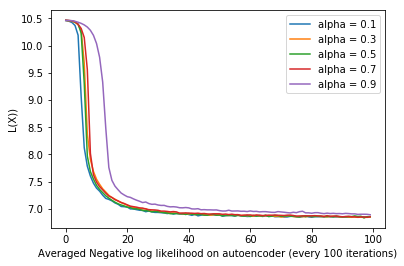

In [5]:
for a in ae_loss:
    plt.plot(a["loss"],label=a["lable"])
plt.legend(loc=1)
plt.xlabel('Averaged Negative log likelihood on autoencoder (every 100 iterations)')
plt.ylabel('L(X))')
plt.savefig('ae_loss' + '.png')
plt.show()

In [1]:
for a in rnn_loss[2:]:
    plt.plot(a["loss"],label=a["lable"])
r = rnn_loss[0]
plt.plot(r["loss"], label=r["lable"])
r = rnn_loss[1]
plt.plot(r["loss"], label=r["lable"])

plt.legend(loc=1)
plt.xlabel('Averaged Negative log likelihood on rnn (every 100 iterations)')
plt.ylabel('L(X))')

plt.show()

NameError: name 'rnn_loss' is not defined

## 4.2 Output predictions 
This section includes sampled sentences from AE + RNN and RNNLM models. The inverse transform sampling method is used to draw samples.
Table below shows the output predictions of AE + RNN with sentences given to autoencoder 

|     Origin   |since 2006 , 75 iranians athletes have been to the united states in an exchange program , reuters reported . |
| -------| -------------------------|
| alpha = 0.1      | - - as were had had not <\s> <\s> <\s> . . . . <\s> . . <\s> <\s> . <s>|
| alpha = 0.5      | - family - down down down down down reports down reports down down down reports come come come come down really |
| alpha = 0.9      | example - state state state state state state come state state state state any any state state state state state </s> |


|     Origin   |during medical school in my native oklahoma , i once saw a breast enhancement surgery performed under local anesthetic . |
| -------| -------------------------|
| alpha = 0.1      |and and and and ? ? ? and near ? near near near would near near near much would originally the |
| alpha = 0.5      | president president president on on on made made made made made made made made made made made made made made chicago  |
| alpha = 0.9      |  president president president and and president and and and and and president president and and president and and and and and |

|     Origin   |as for protecting the marine environment , the law spells out both national and internationally agreed pollution control measures . |
| -------| -------------------------|
| alpha = 0.1      | at at <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> . . . . . . . in|
| alpha = 0.5      | at at <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> . . . . . . if  |
| alpha = 0.9      |  at be be 10 10 10 10 10 10 10 10 two 10 10 10 . . . . . 10 |

|     Origin   |and , with only one or two <unk> , it was time for handshakes all round at the tote .  |
| -------| -------------------------|
| alpha = 0.1      | take . . . . . of of of . of of of of of of of of of of of|
| alpha = 0.5      | of ' . . . . . . . . . . . . . . . . . . .  |
| alpha = 0.9      | of of of she of she of she of she she she . . . . . however she she given |

The table below shows sampled sentences from RNNLM

|       Samples from RNNLM  |
 |-------------------------|
|lockerbie <s> <s> <s> was <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s>|
|argentina for <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> . <s> |
|diluting assurance <\s> <\s> <\s> <\s> . . . . . . . . . . . . . . in|
|<s> <s> <s> was <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s>|
|locked <\s> <\s> <\s> <\s> <\s> . . . . . <\s> . . <\s> <\s> . <\s> <\s> . <s> |
|provisionally expedition for <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> . . . . . . . . . <s>|
|blockbuster obstacle <\s> <\s> <\s> , <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> and <s>|
|scrawled lagos , <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> and <s>|
|inducements arriving of <\s> <\s> <\s> <\s> <\s> <\s> <\s> <\s> of <\s> <\s> <\s> of <\s> <\s> <\s> of <s>|




# 5. Next steps

To be discussed 